# Setup

## Check Python version

In [734]:
from platform import  python_version

In [735]:
python_version()

'3.10.5'

## Install/Download necessary packages

In [736]:
import sys

In [737]:
# # Uncomment these if any packages are not installed in your current jupyter env 
# # Installing a pip package in the current kernel
# # Pandas also installs the numpy package
# !{sys.executable} -m pip install pandas  
# !{sys.executable} -m pip install requests
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install featuretools

In [738]:
# import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
import os
import datetime as dt
import featuretools as ft
from featuretools.selection import selection
from IPython.core.interactiveshell import InteractiveShell 
import inspect
from functools import reduce

# Importing and Preprocessing the Data

In [739]:
def view_files():
    path = os.getcwd()
    path = f"{path}\data"
    return(os.listdir(path))

view_files()

['absa2.csv',
 'absa_jup.csv',
 'AllShares_growth.csv',
 'banks_data',
 'capitec.csv',
 'fnb.csv',
 'household_financial_assets-currency_and_deposits.csv',
 'investec.csv',
 'investment_Qgrowth.csv',
 'inv_by_assets_intellectual.csv',
 'nedbank.csv',
 'share_prices.csv',
 'standard_bank.csv']

## Importing and Cleaning

In [740]:
def check_file(file):
    #grab the file path from which to import the dataset
    path = os.getcwd()
    path = f"{path}\data"
    path = f"{path}\{file}"
    return(path)

In [741]:
check_file("absa.csv")

'C:\\GitHub\\DS_PROJ\\data\\absa.csv'

In [742]:
def import_data(path):
    # read the csv file as a dataframe and remove unnecessary columns
    df = pd.read_csv(filepath_or_buffer=path)
    return(df)

In [743]:
absa = import_data(check_file("absa2.csv"))
absa.head(1)

,Bank,Unit,Table,Time series code,D_M_1993M01: 1993M01,D_M_1993M02: 1993M02,D_M_1993M03: 1993M03,D_M_1993M04: 1993M04,D_M_1993M05: 1993M05,D_M_1993M06: 1993M06,...,D_M_2021M07: 2021M07,D_M_2021M08: 2021M08,D_M_2021M09: 2021M09,D_M_2021M10: 2021M10,D_M_2021M11: 2021M11,D_M_2021M12: 2021M12,D_M_2022M01: 2022M01,D_M_2022M02: 2022M02,D_M_2022M03: 2022M03,D_M_2022M04: 2022M04
0,B_34118: Absa Bank Ltd,U_RT: R'000 (thousands),T_T01: Table 1: LIABILITIES AT MONTH-END,RBD-B_34118-T_T01-U_RT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is not stored in the format typically useful for the pandas framework.

First, the unnecessary variables/indicators such as `Units` and `Time series code"` 

is be removed or transformed and the excessive variable naming trimmed.

In [744]:
def clean_names1(df, bank_prefix="B_34118: "):
    df = df.drop(["Unit", "Time series code"], axis="columns")
    
    # Remove ugly string labels of columns
    df.columns = df.columns.str.replace(pat="D_M_[0-9]{4}M[0-9]{2}:", repl="", regex=True)
    df["Bank"] = df["Bank"].str.replace(pat=bank_prefix, repl="", regex=True)
    df["Bank"] = df["Bank"].str.replace(pat = " ", repl = "_")
    return(df)
    

In [745]:
absa = clean_names1(absa)

In [746]:
absa.head(1)

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below is a check to ensure that all the rows that have lable 

`T_T[0-9]{2}R[0-9]{3}:` or `T_T[0-9]{2}R[0-9]{3}_A:` do not

contain any observations and can therefore be removed

In [747]:
InteractiveShell.ast_node_interactivity = "all"

In [748]:
all(absa[absa["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}:", 
                                    regex = True)].isna().sum(axis=1, 
                                                              skipna=False) == len(absa.columns) - 2);
all(absa[absa["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}_A:", 
                                    regex = True)].isna().sum(axis=1, 
                                                              skipna=False) == len(absa.columns) - 2)

True

True

In [749]:
InteractiveShell.ast_node_interactivity = "last"

Now, we can remove the rows that contain the labels

mentioned above

In [750]:
def remove_empty(df):
    # Remove empty title rows
    df = df[~df["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}:", regex = True)]
    df = df[~df["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}_A:", regex = True)]
    
    return(df)

In [751]:
absa = remove_empty(absa)

In [752]:
absa.head(1)

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [753]:
# absa.loc[absa["Table"].str.contains("T_T01R[0-9]{3}C[0-9]{2}: T01R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
#                                regex=True), :].iloc[:,1:3].set_index("Table").head(15)

absa.loc[absa["Table"].str.contains("T_T01R001|T_T01R002|T_T02R032", 
                               regex=True), :].iloc[:,1:3].set_index("Table")

,1993M01
Table,
T_T01R001C01: T01R001C01: DEPOSITS (total of items 2 and 32): Cheque (1),9588342.0
T_T01R001C02: T01R001C02: DEPOSITS (total of items 2 and 32): Savings (2),7800740.0
T_T01R001C03: T01R001C03: DEPOSITS (total of items 2 and 32): Up to 1 day (3),8946659.0
T_T01R001C04: T01R001C04: DEPOSITS (total of items 2 and 32): More than 1 day to 1 month (4),9417927.0
T_T01R001C05: T01R001C05: DEPOSITS (total of items 2 and 32): More than 1 month to 6 months (5),21301640.0
T_T01R001C06: T01R001C06: DEPOSITS (total of items 2 and 32): More than 6 months (6),8981624.0
T_T01R001C07: T01R001C07: DEPOSITS (total of items 2 and 32): TOTAL (7),66036932.0
T_T01R001C08: T01R001C08: DEPOSITS (total of items 2 and 32): NCDs/PNs i (included in col. 7) (8),NaN
"T_T01R002C01: T01R002C01: DEPOSITS DENOMINATED IN RAND (total of items 3, 6, 12, 13 and 29): Cheque (1)",9588342.0


In [754]:
66034650.0 + 2282.0 == 66036932.0

# i.e. what we have above is
r_001 = absa.loc[absa["Table"].str.contains("DEPOSITS [(]total of items 2 and 32[)]: TOTAL [(]7[)]"),
        :].iloc[:,3]
r_002 = absa.loc[absa["Table"].str.contains("DEPOSITS DENOMINATED IN RAND [(]total of items 3, 6, 12, 13 and 29[)]: TOTAL [(]7[)]"),
          :].iloc[:,3]
r_032 = absa.loc[absa["Table"].str.contains("DEPOSITS DENOMINATED IN FOREIGN CURRENCY [(]total of items 33 to 38[)]: TOTAL [(]7[)]"),
          :].iloc[:,3]
int(r_001) == int(r_002) + int(r_032)


True

In [755]:
any(absa["Table"].str.contains("of which", case=False))
absa[absa["Table"].str.contains("Of which : in foreign currency", case=False)]["Table"]

377    T_T03R041C14: T03R041C14: OTHER BORROWED FUNDS...
383    T_T03R042C14: T03R042C14: Loans received under...
389    T_T03R043C14: T03R043C14: SA Reserve Bank and ...
395    T_T03R044C14: T03R044C14: SA banksb: Of which ...
401    T_T03R450C14: T03R045AC14: Insurers and pensio...
407    T_T03R045C14: T03R045C14: Insurersg: Of which ...
413    T_T03R046C14: T03R046C14: Pension funds: Of wh...
419    T_T03R470C14: T03R047AC14: Financial and non-f...
425    T_T03R047C14: T03R047C14: Other financial corp...
431    T_T03R048C14: T03R048C14: Non-financial corpor...
437    T_T03R049C14: T03R049C14: Foreign sector: Of w...
443    T_T03R050C14: T03R050C14: Other: Of which : in...
449    T_T03R051C14: T03R051C14: Collateralised borro...
455    T_T03R052C14: T03R052C14: SA banksb: Of which ...
461    T_T03R530C14: T03R053AC14: Financial corporate...
467    T_T03R053C14: T03R053C14: Financial corporate ...
473    T_T03R054C14: T03R054C14: Non-financial corpor...
479    T_T03R055C14: T03R055C14

And finally, we can remove the ugly naming

In [756]:
# def clean_names2(df):
#     # Label the different tables withing the df, i.e liablities, assets, etc.
#     df["Table"] = df["Table"].str.replace("T_T0[0-4]R[0-9]{3,4}C[0-9]{2}: T0[1-4]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
#                                           regex = True, repl="L_")
#     df["Table"] = df["Table"].str.replace("T_T0[5]R[0-9]{3,4}C[0-9]{2}: T0[5]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
#                                       regex = True, repl="E_")
#     df["Table"] = df["Table"].str.replace("T_T0[6-9]R[0-9]{3,4}C[0-9]{2}: T0[6-9]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
#                                           regex = True, repl="A_")
#     df["Table"] = df["Table"].str.replace("T_T1[0-3]R[0-9]{3,4}C[0-9]{2}: T1[0-3]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
#                                           regex = True, repl="A_")
#     #  remove bracket explanations
#     df["Table"] = df["Table"].str.replace("[(][0-9a-z\s,]{2,}[)][:] ", regex = True, repl="")
#     return(df)

In [757]:
def clean_names2(df):
    # Label the different tables withing the df, i.e liablities, assets, etc.
    df["Table"] = df["Table"].str.replace("T_T0[1-2](R[0-9]{3,4})C[0-9]{2}: T0[1-2]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"L_T1-2_\1_")
    df["Table"] = df["Table"].str.replace("T_T0[3-4](R[0-9]{3,4})C[0-9]{2}: T0[3-4]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"L_T3-4_\1_")
    df["Table"] = df["Table"].str.replace("T_T0[5](R[0-9]{3,4})C[0-9]{2}: T0[5]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                      regex = True, repl=r"E_T5_\1_")
    df["Table"] = df["Table"].str.replace("T_T0[6-9](R[0-9]{3,4})C[0-9]{2}: T0[6-9]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"A_T6-13_\1_")
    df["Table"] = df["Table"].str.replace("T_T1[0-3](R[0-9]{3,4})C[0-9]{2}: T1[0-3]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"A_T6-13_\1_")
    df["Table"] = df["Table"].str.replace(",", "")
    # remove bracket explanations
#     df["Table"] = df["Table"].str.replace("[(][0-9a-z\s,]{2,}[)][:] ", regex = True, repl="")
    return(df)

The lines below are only clear after completing the entire sequence of steps followed

in this project and plotting the `Central bank money and gold`  variable over time.

The total column for this feature is empty from around 2005 and we need to specifically

impute the missing values from its subcategory. Similar issues are also present for 
the `Deposits, Loans, and Advances` and `Non-financial Assets`

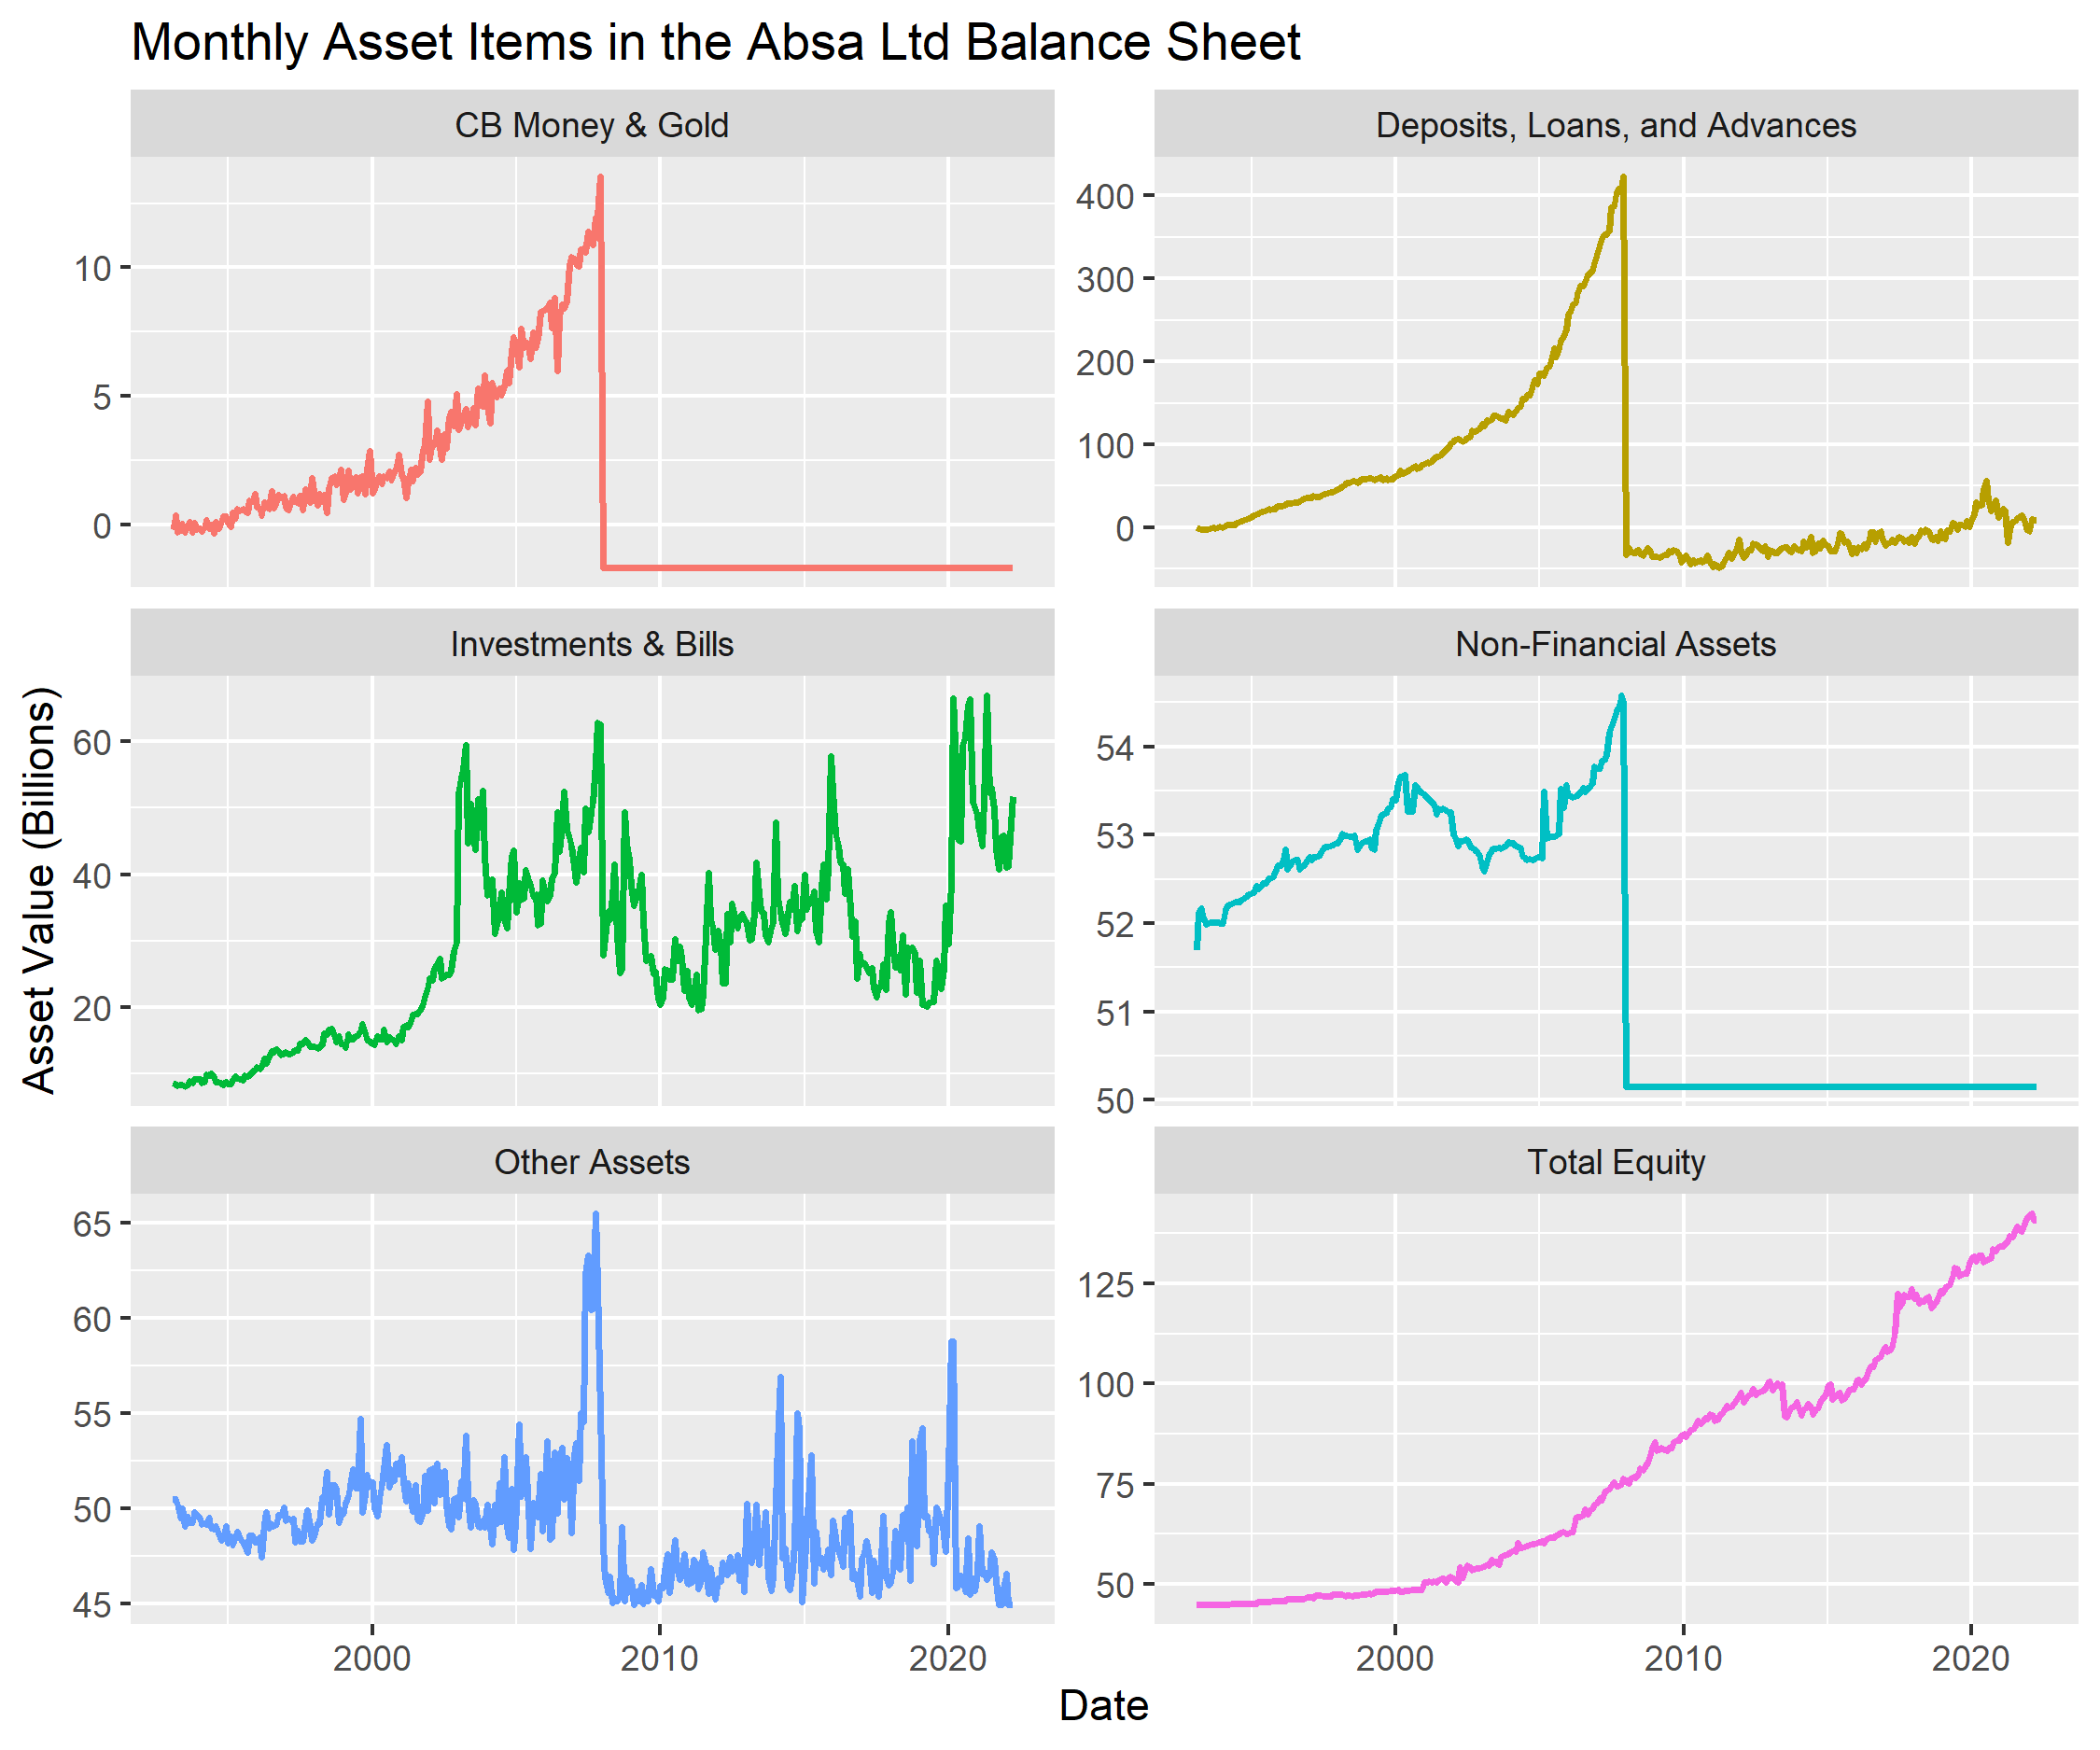

In [758]:
from IPython.display import Image
Image("./figures/missing_totals.png")

In [759]:
absa.loc[absa["Table"].str.contains("Central.{,3}Bank", regex=True, case=False),][["Table", 
                                                   " 2007M11", " 2007M12", " 2008M01", " 2008M02", " 2022M04"]]

,Table,2007M11,2007M12,2008M01,2008M02,2022M04
758,T_T06R103C18: T06R103C18: CENTRAL BANK MONEY A...,13645297.0,15190112.0,13758992.0,13315198.0,33454208.0
759,T_T06R103C19: T06R103C19: CENTRAL BANK MONEY A...,NaN,NaN,NaN,NaN,NaN
760,T_T06R103C21: T06R103C21: CENTRAL BANK MONEY A...,0.0,0.0,NaN,NaN,0.0
761,T_T06R103C22: T06R103C22: CENTRAL BANK MONEY A...,NaN,NaN,NaN,NaN,NaN
762,T_T06R103C24: T06R103C24: CENTRAL BANK MONEY A...,13645297.0,15190112.0,0.0,0.0,0.0
763,T_T06R103C25: T06R103C25: CENTRAL BANK MONEY A...,0.0,0.0,NaN,NaN,0.0


In [760]:
repl1 = absa["Table"].str.contains("T_T06R103C24: T06R103C24:", regex=True, case=False)
with1 = absa["Table"].str.contains("T_T06R103C18: T06R103C18:", regex=True, case=False)

absa.loc[repl1,:] = absa.loc[repl1,:].replace(list(absa.loc[repl1,:].iloc[0,2:]), 1)
absa.loc[repl1, " 1993M01":] = absa.loc[repl1, " 1993M01":].cumsum(axis=1)
absa.loc[repl1,:]

absa.loc[repl1,:] = absa.loc[repl1,:].replace(list(absa.loc[repl1,:].iloc[0,2:]), 
                                              list(absa.loc[with1,:].iloc[0,2:]))

In [761]:
# repl1 = absa["Table"].str.contains("T_T06R103C24: T06R103C24:", regex=True, case=False)
# with1 = absa["Table"].str.contains("T_T06R103C18: T06R103C18:", regex=True, case=False)
# joint = absa.loc[with1,:].iloc[0,2:].add(absa.loc[repl1,:].iloc[0,2:])[" 2008M01":]
# with1b = list(absa.loc[repl1,:].iloc[0,2:][:" 2007M12"].append(joint))
# joint[" 2008M01":]
# absa.loc[repl1,:].loc[:, " 2008M01":] = list(joint[" 2008M01":])
# # absa.loc[repl1,:].replace(list(absa.loc[repl1,:].iloc[0,2:]), 
# #                                               list(with1b))

In [762]:
absa.loc[repl1,:]

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
762,Absa_Bank_Ltd,T_T06R103C24: T06R103C24: CENTRAL BANK MONEY A...,1659838.0,1475877.0,2027696.0,1394141.0,1448786.0,1697931.0,1382905.0,1664082.0,...,32530732.0,32793938.0,32659198.0,32083628.0,33160199.0,33559153.0,22214272.0,33115552.0,34359466.0,33454208.0


In [763]:
absa.loc[repl1,:].iloc[0,2:]
#absa.loc[with1,:].iloc[0,2:]

 1993M01     1659838.0
 1993M02     1475877.0
 1993M03     2027696.0
 1993M04     1394141.0
 1993M05     1448786.0
               ...    
 2021M12    33559153.0
 2022M01    22214272.0
 2022M02    33115552.0
 2022M03    34359466.0
 2022M04    33454208.0
Name: 762, Length: 352, dtype: object

In [764]:
absa.loc[repl1,:]

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
762,Absa_Bank_Ltd,T_T06R103C24: T06R103C24: CENTRAL BANK MONEY A...,1659838.0,1475877.0,2027696.0,1394141.0,1448786.0,1697931.0,1382905.0,1664082.0,...,32530732.0,32793938.0,32659198.0,32083628.0,33160199.0,33559153.0,22214272.0,33115552.0,34359466.0,33454208.0


In [765]:
absa.loc[absa["Table"].str.contains("Deposits, loans", 
                                    regex=True, 
                                    case=False),]#[["Table", " 2007M11", " 2007M12", " 2008M01", " 2008M02"]]

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
807,Absa_Bank_Ltd,"T_T06R110C18: T06R110C18: DEPOSITS, LOANS AND ...",64047968.0,65947855.0,64696818.0,63307284.0,63139892.0,63178459.0,64254248.0,65044752.0,...,900001589.0,912977212.0,926291034.0,930239471.0,973512169.0,956047585.0,938001855.0,941540133.0,942356062.0,952401151.0
808,Absa_Bank_Ltd,"T_T06R110C19: T06R110C19: DEPOSITS, LOANS AND ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
809,Absa_Bank_Ltd,"T_T06R110C21: T06R110C21: DEPOSITS, LOANS AND ...",937381.0,838561.0,811696.0,504127.0,949588.0,814481.0,408669.0,369640.0,...,51067949.0,52016315.0,52100644.0,52745582.0,53468243.0,52749188.0,52977051.0,53516247.0,51851753.0,53561665.0
810,Absa_Bank_Ltd,"T_T06R110C22: T06R110C22: DEPOSITS, LOANS AND ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
811,Absa_Bank_Ltd,"T_T06R110C24: T06R110C24: DEPOSITS, LOANS AND ...",64985349.0,66786416.0,65508514.0,63811411.0,64089480.0,63992940.0,64662917.0,65414392.0,...,74529667.0,77663925.0,78899748.0,81178798.0,74540284.0,64701459.0,62134502.0,76409017.0,75906076.0,75427581.0
812,Absa_Bank_Ltd,"T_T06R110C25: T06R110C25: DEPOSITS, LOANS AND ...",NaN,NaN,NaN,51000.0,NaN,67000.0,76000.0,81000.0,...,57435201.0,60076132.0,59485984.0,58404757.0,65695050.0,51309794.0,48540893.0,59137706.0,58564677.0,58874042.0


In [766]:
absa.loc[absa["Table"].str.contains("NON-FINANCIAL", 
                                    regex=True),][["Table", 
                                                   " 2007M11", " 2007M12", " 2008M01", " 2008M02"]]

,Table,2007M11,2007M12,2008M01,2008M02
1948,T_T13R258C18: T13R258C18: NON-FINANCIAL ASSETS...,4425493.0,4360173.0,4346590.0,4354713.0
1949,T_T13R258C20: T13R258C20: NON-FINANCIAL ASSETS...,NaN,NaN,NaN,NaN
1950,T_T13R258C21: T13R258C21: NON-FINANCIAL ASSETS...,0.0,0.0,NaN,NaN
1951,T_T13R258C23: T13R258C23: NON-FINANCIAL ASSETS...,NaN,NaN,NaN,NaN
1952,T_T13R258C24: T13R258C24: NON-FINANCIAL ASSETS...,4425493.0,4360173.0,0.0,0.0
1953,T_T13R258C25: T13R258C25: NON-FINANCIAL ASSETS...,NaN,NaN,NaN,NaN


In [767]:
absa.loc[absa["Table"].str.contains("OTHER ASSETS", 
                                    regex=True),][["Table", 
                                                   " 2007M11", " 2007M12", " 2008M01", " 2008M02"]]

,Table,2007M11,2007M12,2008M01,2008M02
2011,T_T13R267C18: T13R267C18: OTHER ASSETS (total ...,16799115.0,10121892.0,19805087.0,13059691.0
2012,T_T13R267C20: T13R267C20: OTHER ASSETS (total ...,NaN,NaN,NaN,NaN
2013,T_T13R267C21: T13R267C21: OTHER ASSETS (total ...,0.0,0.0,NaN,NaN
2014,T_T13R267C23: T13R267C23: OTHER ASSETS (total ...,NaN,NaN,NaN,NaN
2015,T_T13R267C24: T13R267C24: OTHER ASSETS (total ...,16799115.0,10121892.0,3112576.0,1314520.0
2016,T_T13R267C25: T13R267C25: OTHER ASSETS (total ...,NaN,NaN,NaN,NaN


In [768]:
test1 = absa.loc[absa["Table"].str.contains("OTHER ASSETS", 
                                    regex=True),].loc[2011," 1993M01" : " 2007M12"].fillna(0)
test2 = absa.loc[absa["Table"].str.contains("OTHER ASSETS", 
                                    regex=True),].loc[2015," 1993M01" : " 2007M12"].fillna(0)
#sum(test1 == test2), len(test1)
test1[test1 != test2], test2[test1 != test2]

( 1994M04    4219413.0
 Name: 2011, dtype: float64,
  1994M04    4219944.0
 Name: 2015, dtype: float64)

In [769]:
def fill_totals(df):
    # CB money
#     repl1 = df["Table"].str.contains("T_T06R103C24: T06R103C24:", regex=True, case=False)
#     with1 = df["Table"].str.contains("T_T06R103C18: T06R103C18:", regex=True, case=False)

#     df.loc[repl1,:] = df.loc[repl1,:].replace(list(df.loc[repl1,:].iloc[0,2:]), 
#                                             list(df.loc[with1,:].iloc[0,2:]))

    repl1 = df["Table"].str.contains("T_T06R103C24: T06R103C24:", regex=True, case=False)
    with1 = df["Table"].str.contains("T_T06R103C18: T06R103C18:", regex=True, case=False)

    df.loc[repl1,:] = df.loc[repl1,:].replace(list(df.loc[repl1,:].iloc[0,2:]), 1)
    df.loc[repl1, " 1993M01":] = df.loc[repl1, " 1993M01":].cumsum(axis=1)

    df.loc[repl1,:] = df.loc[repl1,:].replace(list(df.loc[repl1,:].iloc[0,2:]), 
                                                  list(df.loc[with1,:].iloc[0,2:]))
    # Deposits
    repl2 = df["Table"].str.contains("T_T06R110C24: T06R110C24:", regex=True, case=False)
    with2 = df["Table"].str.contains("T_T06R110C18: T06R110C18:", regex=True, case=False)
    joint1 = df.loc[with2,:].iloc[0,2:].add(df.loc[repl2,:].iloc[0,2:])[" 2008M01":]
    with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))

    df.loc[repl2,:] = df.loc[repl2,:].replace(list(df.loc[repl2,:].iloc[0,2:]), 
                                                  list(with2b))
    
    # NON-FINANCIAL ASSETS
#     repl3 = df["Table"].str.contains("T_T13R258C24: T13R258C24:", regex=True, case=False)
#     with3 = df["Table"].str.contains("T_T13R258C18: T13R258C18:", regex=True, case=False)

#     df.loc[repl3,:] = df.loc[repl3,:].replace(list(df.loc[repl3,:].iloc[0,2:]), 
#                                             list(df.loc[with3,:].iloc[0,2:]))

    repl3 = df["Table"].str.contains("T_T13R258C24: T13R258C24:", regex=True, case=False)
    with3 = df["Table"].str.contains("T_T13R258C18: T13R258C18:", regex=True, case=False)
    
    df.loc[repl3,:] = df.loc[repl3,:].replace(list(df.loc[repl3,:].iloc[0,2:]), 1)
    df.loc[repl3, " 1993M01":] = df.loc[repl3, " 1993M01":].cumsum(axis=1)

    df.loc[repl3,:] = df.loc[repl3,:].replace(list(df.loc[repl3,:].iloc[0,2:]), 
                                            list(df.loc[with3,:].iloc[0,2:]))
    
    # OTHER ASSETS
    repl4 = df["Table"].str.contains("T_T13R267C24: T13R267C24:", regex=True, case=False)
    with4a = df["Table"].str.contains("T_T13R267C21: T13R267C21:", regex=True, case=False)
    with4b = df["Table"].str.contains("T_T13R267C18: T13R267C18:", regex=True, case=False)
    joint2 = df.loc[with4a,:].fillna(0).iloc[0,2:].add(df.loc[with4b,:].fillna(0).iloc[0,2:])

    df.loc[repl4,:] = df.loc[repl4,:].replace(list(df.loc[repl4,:].iloc[0,2:]), 
                                            list(joint2))
    
    return(df)

In [770]:
absa = fill_totals(absa)

C:\Users\gerar\AppData\Local\Temp\ipykernel_14328\3438252180.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


In [771]:
absa

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Absa_Bank_Ltd,T_T01R001C01: T01R001C01: DEPOSITS (total of i...,9588342.0,11392410.0,10668670.0,11432864.0,11014770.0,11042960.0,10561166.0,12471006.0,...,218471395.0,209031404.0,215453291.0,214590582.0,218067373.0,230444938.0,202177025.0,208657411.0,221079725.0,220710857.0
3,Absa_Bank_Ltd,T_T01R001C02: T01R001C02: DEPOSITS (total of i...,7800740.0,7555104.0,7670861.0,7780098.0,7756258.0,7709445.0,7722106.0,7613571.0,...,219810888.0,219708150.0,219832044.0,220612457.0,224095757.0,225800105.0,223125550.0,216880586.0,216446346.0,218785374.0
4,Absa_Bank_Ltd,T_T01R001C03: T01R001C03: DEPOSITS (total of i...,8946659.0,6782139.0,9577124.0,8180529.0,7692343.0,8151043.0,8020508.0,8174811.0,...,140121157.0,160037358.0,164035947.0,167933686.0,181585523.0,150430271.0,171484466.0,174135086.0,172916558.0,164697147.0
5,Absa_Bank_Ltd,T_T01R001C04: T01R001C04: DEPOSITS (total of i...,9417927.0,9651219.0,9436300.0,9473765.0,9701689.0,9933172.0,9589893.0,9227178.0,...,78737825.0,59329833.0,60904840.0,66533680.0,60978989.0,81578456.0,68695763.0,65715791.0,63862009.0,85939653.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,Absa_Bank_Ltd,T_T13R277C20: T13R277C20: TOTAL ASSETS (total ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2083,Absa_Bank_Ltd,T_T13R277C21: T13R277C21: TOTAL ASSETS (total ...,937881.0,839061.0,812196.0,504627.0,950088.0,814981.0,409169.0,370140.0,...,52670911.0,53912565.0,55315248.0,54637880.0,57076273.0,55828960.0,58033424.0,60998142.0,57034200.0,59875968.0
2084,Absa_Bank_Ltd,T_T13R277C23: T13R277C23: TOTAL ASSETS (total ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2085,Absa_Bank_Ltd,T_T13R277C24: T13R277C24: TOTAL ASSETS (total ...,79593628.0,81404394.0,81034337.0,78063262.0,77755058.0,78371846.0,77567705.0,79331923.0,...,127733124.0,127216868.0,121372441.0,119401796.0,117699282.0,108863961.0,102269580.0,115017291.0,120936069.0,124521793.0


In [772]:
absa = clean_names2(absa)

In [773]:
absa.head(1)

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [774]:
list(absa["Table"])

['T_T01: Table 1: LIABILITIES AT MONTH-END',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Cheque (1)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Savings (2)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Up to 1 day (3)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 day to 1 month (4)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 month to 6 months (5)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 6 months (6)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): TOTAL (7)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): NCDs/PNs i  (included in col. 7) (8)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): Cheque (1)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): Savings (2)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): Up to 1 day (3)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): More tha

In [775]:
# totals = 
list(absa[absa["Table"].str.contains("total", case=False)]["Table"])

['L_T1-2_R001_DEPOSITS (total of items 2 and 32): Cheque (1)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Savings (2)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Up to 1 day (3)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 day to 1 month (4)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 month to 6 months (5)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 6 months (6)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): TOTAL (7)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): NCDs/PNs i  (included in col. 7) (8)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): Cheque (1)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): Savings (2)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): Up to 1 day (3)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): More than 1 day to 1 month (4)',
 'L_T1-2_R002_DEPOSI

So we want to exclude several types of columns. That is, 

Those not containing the uppercase label `TOTAL`

First, to make things easier, the data is split into the three

major components of the Balance Sheet. That is, liabilities, 
assets, and equity

The dataframe must frist be transposed to ensure
it is in the correct form for the model from the start

In [776]:
list(absa.loc[absa["Table"].str.contains("TOTAL"),:]["Table"])

['L_T1-2_R001_DEPOSITS (total of items 2 and 32): TOTAL (7)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): TOTAL (7)',
 'L_T1-2_R003_SA banksb (total of items 4 and 5): TOTAL (7)',
 'L_T1-2_R004_NCDs/PNsi: TOTAL (7)',
 'L_T1-2_R005_Other deposits: TOTAL (7)',
 'L_T1-2_R006_Central and provincial government sector depositsc (total of items 7 10 and 11): TOTAL (7)',
 'L_T1-2_R007_Central government of the Republic (total of items 8 and 9): TOTAL (7)',
 'L_T1-2_R008_Tax and loan account: TOTAL (7)',
 'L_T1-2_R009_Other: TOTAL (7)',
 'L_T1-2_R010_Provincial governments: TOTAL (7)',
 'L_T1-2_R011_Social security funds: TOTAL (7)',
 'L_T1-2_R012_Other monetary institutionsh: TOTAL (7)',
 'L_T1-2_R013_Other domestic parties (total of items 14 to 20 25 26 27 and 28): TOTAL (7)',
 'L_T1-2_R014_Local government: TOTAL (7)',
 'L_T1-2_R015_Public financial corporate sectord (such as IDC DBSA): TOTAL (7)',
 'L_T1-2_R016_Public Investment Corporation (PIC): TOTAL (7)

It is clear from the above that the columns containing enough

aggregated information are tagged with `(total of items ...)`

so this can be filtered

In [777]:
test = absa.loc[absa["Table"].str.contains("TOTAL"),:]
list(test.iloc[:,1])

['L_T1-2_R001_DEPOSITS (total of items 2 and 32): TOTAL (7)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): TOTAL (7)',
 'L_T1-2_R003_SA banksb (total of items 4 and 5): TOTAL (7)',
 'L_T1-2_R004_NCDs/PNsi: TOTAL (7)',
 'L_T1-2_R005_Other deposits: TOTAL (7)',
 'L_T1-2_R006_Central and provincial government sector depositsc (total of items 7 10 and 11): TOTAL (7)',
 'L_T1-2_R007_Central government of the Republic (total of items 8 and 9): TOTAL (7)',
 'L_T1-2_R008_Tax and loan account: TOTAL (7)',
 'L_T1-2_R009_Other: TOTAL (7)',
 'L_T1-2_R010_Provincial governments: TOTAL (7)',
 'L_T1-2_R011_Social security funds: TOTAL (7)',
 'L_T1-2_R012_Other monetary institutionsh: TOTAL (7)',
 'L_T1-2_R013_Other domestic parties (total of items 14 to 20 25 26 27 and 28): TOTAL (7)',
 'L_T1-2_R014_Local government: TOTAL (7)',
 'L_T1-2_R015_Public financial corporate sectord (such as IDC DBSA): TOTAL (7)',
 'L_T1-2_R016_Public Investment Corporation (PIC): TOTAL (7)

In [778]:
test = test.loc[test["Table"].str.contains("[(]total of items ", regex=True), ["Table"]]
test.head()

,Table
8,L_T1-2_R001_DEPOSITS (total of items 2 and 32)...
17,L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (tota...
26,L_T1-2_R003_SA banksb (total of items 4 and 5)...
53,L_T1-2_R006_Central and provincial government ...
62,L_T1-2_R007_Central government of the Republic...


In [779]:
dups = test["Table"].str.replace(".*(R[0-9]{3}).*", regex=True, repl=r"\1").duplicated()
dups

8       False
17      False
26      False
53      False
62      False
        ...  
2082     True
2083     True
2084     True
2085     True
2086     True
Name: Table, Length: 85, dtype: bool

In [780]:
# These can all be removed since they are the totals of collections of previous
# totals in the dataframe
list(test.loc[dups,:]["Table"])

['L_T3-4_R078_TOTAL LIABILITIES TO THE PUBLIC (total of items 1 41 58 and 67): Medium-term (2)',
 'L_T3-4_R078_TOTAL LIABILITIES TO THE PUBLIC (total of items 1 41 58 and 67): Long-term (3)',
 'L_T3-4_R078_TOTAL LIABILITIES TO THE PUBLIC (total of items 1 41 58 and 67): TOTAL (4)',
 'L_T3-4_R078_TOTAL LIABILITIES TO THE PUBLIC (total of items 1 41 58 and 67): Of which :  in foreign currency (5)',
 'L_T3-4_R095_TOTAL LIABILITIES (total of items 78 to 80): Medium-term (2)',
 'L_T3-4_R095_TOTAL LIABILITIES (total of items 78 to 80): Long-term (3)',
 'L_T3-4_R095_TOTAL LIABILITIES (total of items 78 to 80): TOTAL (4)',
 'L_T3-4_R095_TOTAL LIABILITIES (total of items 78 to 80): Of which :  in foreign currency (5)',
 'E_T5_R096_TOTAL EQUITY (total of items 97 and 101): Of which: liabilities to the foreign sector (2)',
 'E_T5_R096_TOTAL EQUITY (total of items 97 and 101): Of which: in foreign currency (included in col 1 ) (3)',
 'E_T5_R102_TOTAL EQUITY AND LIABILITIES (total of items 95 and 9

In [781]:
def filter_totals(df):
    df = df.loc[df["Table"].str.contains("TOTAL"),:]
    df = df.loc[df["Table"].str.contains("[(]total of items ", regex=True), :]
    dups = df["Table"].str.replace(".*(R[0-9]{3}).*", regex=True, repl=r"\1").duplicated()
    df = df.loc[~dups,:]
    return(df)

In [782]:
df#.columns == "2020M11"

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Absa_Bank_Ltd,L_T1-2_R001_DEPOSITS (total of items 2 and 32)...,9588342.0,11392410.0,10668670.0,11432864.0,11014770.0,11042960.0,10561166.0,12471006.0,...,218471395.0,209031404.0,215453291.0,214590582.0,218067373.0,230444938.0,202177025.0,208657411.0,221079725.0,220710857.0
3,Absa_Bank_Ltd,L_T1-2_R001_DEPOSITS (total of items 2 and 32)...,7800740.0,7555104.0,7670861.0,7780098.0,7756258.0,7709445.0,7722106.0,7613571.0,...,219810888.0,219708150.0,219832044.0,220612457.0,224095757.0,225800105.0,223125550.0,216880586.0,216446346.0,218785374.0
4,Absa_Bank_Ltd,L_T1-2_R001_DEPOSITS (total of items 2 and 32)...,8946659.0,6782139.0,9577124.0,8180529.0,7692343.0,8151043.0,8020508.0,8174811.0,...,140121157.0,160037358.0,164035947.0,167933686.0,181585523.0,150430271.0,171484466.0,174135086.0,172916558.0,164697147.0
5,Absa_Bank_Ltd,L_T1-2_R001_DEPOSITS (total of items 2 and 32)...,9417927.0,9651219.0,9436300.0,9473765.0,9701689.0,9933172.0,9589893.0,9227178.0,...,78737825.0,59329833.0,60904840.0,66533680.0,60978989.0,81578456.0,68695763.0,65715791.0,63862009.0,85939653.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,Absa_Bank_Ltd,A_T6-13_R277_TOTAL ASSETS (total of items 103 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2083,Absa_Bank_Ltd,A_T6-13_R277_TOTAL ASSETS (total of items 103 ...,937881.0,839061.0,812196.0,504627.0,950088.0,814981.0,409169.0,370140.0,...,52670911.0,53912565.0,55315248.0,54637880.0,57076273.0,55828960.0,58033424.0,60998142.0,57034200.0,59875968.0
2084,Absa_Bank_Ltd,A_T6-13_R277_TOTAL ASSETS (total of items 103 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2085,Absa_Bank_Ltd,A_T6-13_R277_TOTAL ASSETS (total of items 103 ...,79593628.0,81404394.0,81034337.0,78063262.0,77755058.0,78371846.0,77567705.0,79331923.0,...,127733124.0,127216868.0,121372441.0,119401796.0,117699282.0,108863961.0,102269580.0,115017291.0,120936069.0,124521793.0


In [783]:
absa = filter_totals(absa)

In [784]:
InteractiveShell.ast_node_interactivity = "all"

In [785]:
absa.head(1)
absa.info()

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
8,Absa_Bank_Ltd,L_T1-2_R001_DEPOSITS (total of items 2 and 32)...,66036932.0,65948319.0,66446620.0,64813147.0,64317315.0,65148147.0,64450271.0,66006474.0,...,987428308.0,978982466.0,990882087.0,1.002621e+09,1.026975e+09,1.025364e+09,997923770.0,1.011085e+09,1.022591e+09,1.048495e+09


<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 8 to 2081
Columns: 354 entries, Bank to  2022M04
dtypes: float64(352), object(2)
memory usage: 185.8+ KB


In [786]:
InteractiveShell.ast_node_interactivity = "last"

In [787]:
def reformat(df):
    df = df.drop("Bank", axis=1)
    df = df.set_index("Table").T
    df.columns.name = None
    df.index.name = "Date"
    df.index = pd.to_datetime(df.index, format=" %YM%m")
    df.columns = df.columns.str.replace(pat=" ", repl="_")
    df.columns = df.columns.str.replace(pat="total_of_items", repl="tot")
    df = df.apply(pd.to_numeric)
    
    return(df)

In [788]:
absa = reformat(absa)

In [789]:
absa

,L_T1-2_R001_DEPOSITS_(tot_2_and_32):_TOTAL_(7),L_T1-2_R002_DEPOSITS_DENOMINATED_IN_RAND_(tot_3_6_12_13_and_29):_TOTAL_(7),L_T1-2_R003_SA_banksb_(tot_4_and_5):_TOTAL_(7),L_T1-2_R006_Central_and_provincial_government_sector_depositsc_(tot_7_10_and_11):_TOTAL_(7),L_T1-2_R007_Central_government_of_the_Republic_(tot_8_and_9):_TOTAL_(7),L_T1-2_R013_Other_domestic_parties_(tot_14_to_20_25_26_27_and_28):_TOTAL_(7),L_T1-2_R020_Private_financial_corporate_sectore_(tot_21_to_24):_TOTAL_(7),L_T1-2_R029_Foreign_sector_(tot_30_and_31):_TOTAL_(7),L_T1-2_R032_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_(tot_33_to_38):_TOTAL_(7),L_T1-2_R038_Foreign_sector_(tot_39_and_40):_TOTAL_(7),...,A_T6-13_R246_Acceptances_commercial_paper_bills_promissory_notes_and_similar_acknowledgements_of_debt_discounted_or_purchased_(tot_247_250_to_254_and_257):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R247_Bankers'_acceptances_(tot_248_and_249):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R254_Land_Bank_bills_(tot_255_and_256):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R258_NON-FINANCIAL_ASSETS_(tot_259_and_264):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R259_Tangible_assets_(tot_260_to_263):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R264_Intangible_assets_(tot_265_and_266):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R267_OTHER_ASSETS_(tot_268_to_272_and_276):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R268_Clients'_liabilities_per_contra_(tot_280_to_283):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R272_Assets_acquired_or_bought_in_to_protect_an_advance_or_investment_(tot_273_to_275):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R277_TOTAL_ASSETS_(tot_103_110_195_258_and_267):_Domestic_assets_(1)
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-01,6.603693e+07,66034650.0,9340101.0,1238972.0,1023743.0,54180359.0,NaN,1275218.0,2282.0,2282.0,...,122004.0,NaN,NaN,1541557.0,1173537.0,NaN,5228902.0,3577948.0,NaN,7.865575e+07
1993-02-01,6.594832e+07,65946508.0,7342899.0,1153121.0,883687.0,56171183.0,NaN,1279305.0,1811.0,1811.0,...,124212.0,NaN,NaN,1543777.0,1177358.0,NaN,5541530.0,3311092.0,NaN,8.056533e+07
1993-03-01,6.644662e+07,66444850.0,7094763.0,2424744.0,2202394.0,55828437.0,NaN,1096906.0,1770.0,1770.0,...,143389.0,NaN,48626.0,1969848.0,1599051.0,NaN,5560926.0,3451182.0,NaN,8.022214e+07
1993-04-01,6.481315e+07,64811391.0,5858248.0,1222010.0,956580.0,56569531.0,NaN,1161602.0,1756.0,1756.0,...,147137.0,NaN,NaN,2018578.0,1639781.0,NaN,5273498.0,3093337.0,NaN,7.755864e+07
1993-05-01,6.431732e+07,64315553.0,4455192.0,1452509.0,1140486.0,56186211.0,NaN,1170514.0,1762.0,1762.0,...,2313651.0,NaN,888673.0,1923699.0,1558462.0,NaN,4564490.0,2875939.0,NaN,7.680497e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,1.025364e+09,969525149.0,74043961.0,84466156.0,72963540.0,777565198.0,154672857.0,13455772.0,55838418.0,19556815.0,...,11205152.0,NaN,NaN,22265492.0,14.0,0.0,20746734.0,0.0,0.0,1.244072e+09
2022-01-01,9.979238e+08,942489021.0,76540882.0,60756325.0,49547141.0,766702422.0,157463170.0,15710556.0,55434749.0,17981285.0,...,6524698.0,NaN,NaN,22053933.0,13.0,0.0,37495833.0,0.0,0.0,1.216991e+09
2022-02-01,1.011085e+09,955334991.0,83899831.0,58478887.0,47578108.0,776108179.0,160886115.0,12397194.0,55750362.0,19490661.0,...,4925175.0,NaN,NaN,22395415.0,12.0,0.0,45802912.0,0.0,0.0,1.237919e+09


In [790]:
absa.iloc[:,absa.columns.str.startswith(("L_"))]

,L_T1-2_R001_DEPOSITS_(tot_2_and_32):_TOTAL_(7),L_T1-2_R002_DEPOSITS_DENOMINATED_IN_RAND_(tot_3_6_12_13_and_29):_TOTAL_(7),L_T1-2_R003_SA_banksb_(tot_4_and_5):_TOTAL_(7),L_T1-2_R006_Central_and_provincial_government_sector_depositsc_(tot_7_10_and_11):_TOTAL_(7),L_T1-2_R007_Central_government_of_the_Republic_(tot_8_and_9):_TOTAL_(7),L_T1-2_R013_Other_domestic_parties_(tot_14_to_20_25_26_27_and_28):_TOTAL_(7),L_T1-2_R020_Private_financial_corporate_sectore_(tot_21_to_24):_TOTAL_(7),L_T1-2_R029_Foreign_sector_(tot_30_and_31):_TOTAL_(7),L_T1-2_R032_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_(tot_33_to_38):_TOTAL_(7),L_T1-2_R038_Foreign_sector_(tot_39_and_40):_TOTAL_(7),...,L_T3-4_R058_FOREIGN_CURRENCY_FUNDING_(tot_59_to_63_and_66):_TOTAL_(4),L_T3-4_R067_OTHER_LIABILITIES_TO_THE_PUBLIC_(tot_68_73_74_and_77):_TOTAL_(4),L_T3-4_R068_Debt_securities:_(tot_69_to_72):_TOTAL_(4),L_T3-4_R074_Other_(tot_75_and_76):_TOTAL_(4),L_T3-4_R078_TOTAL_LIABILITIES_TO_THE_PUBLIC_(tot_1_41_58_and_67):_Short-term_(1),L_T3-4_R080_OTHER_LIABILITIES_(tot_81_85_86_90_91_and_94):_TOTAL_(4),L_T3-4_R081_Liabilities_i.r.o_derivative_instruments:_to_domestic_sector_(tot_82_to_84):_TOTAL_(4),L_T3-4_R086_Other_trading_liabilities_(excluding_derivatives):_to_domestic_sector_(tot_87_to_89):_TOTAL_(4),L_T3-4_R091_Other_liabilities:_to_domestic_sector_(tot_92_and_93):_TOTAL_(4),L_T3-4_R095_TOTAL_LIABILITIES_(tot_78_to_80):_Short-term_(1)
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-01,6.603693e+07,66034650.0,9340101.0,1238972.0,1023743.0,54180359.0,NaN,1275218.0,2282.0,2282.0,...,3914415.0,890830.0,NaN,432645.0,38199384.0,48375.0,NaN,NaN,48375.0,41825706.0
1993-02-01,6.594832e+07,65946508.0,7342899.0,1153121.0,883687.0,56171183.0,NaN,1279305.0,1811.0,1811.0,...,4011103.0,1163403.0,NaN,421806.0,38708005.0,409408.0,NaN,NaN,409408.0,42428505.0
1993-03-01,6.644662e+07,66444850.0,7094763.0,2424744.0,2202394.0,55828437.0,NaN,1096906.0,1770.0,1770.0,...,4324758.0,999009.0,NaN,761229.0,40502925.0,40645.0,NaN,NaN,40645.0,43994752.0
1993-04-01,6.481315e+07,64811391.0,5858248.0,1222010.0,956580.0,56569531.0,NaN,1161602.0,1756.0,1756.0,...,3858337.0,941248.0,NaN,583016.0,39037928.0,39945.0,NaN,NaN,39945.0,42171610.0
1993-05-01,6.431732e+07,64315553.0,4455192.0,1452509.0,1140486.0,56186211.0,NaN,1170514.0,1762.0,1762.0,...,4043798.0,1500329.0,NaN,899079.0,38184397.0,47131.0,NaN,NaN,47131.0,41107367.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,1.025364e+09,969525149.0,74043961.0,84466156.0,72963540.0,777565198.0,154672857.0,13455772.0,55838418.0,19556815.0,...,86112.0,65220729.0,60874922.0,0.0,765032283.0,89087148.0,28579204.0,21146258.0,15053098.0,834200962.0
2022-01-01,9.979238e+08,942489021.0,76540882.0,60756325.0,49547141.0,766702422.0,157463170.0,15710556.0,55434749.0,17981285.0,...,83140.0,62932589.0,59891887.0,0.0,742181990.0,88157362.0,23261773.0,21147825.0,20445284.0,804531069.0
2022-02-01,1.011085e+09,955334991.0,83899831.0,58478887.0,47578108.0,776108179.0,160886115.0,12397194.0,55750362.0,19490661.0,...,129230.0,62710912.0,59864949.0,0.0,757025034.0,90975660.0,23959742.0,21209727.0,26563602.0,819278316.0


In [791]:
def liabilities(df):
    df = df.iloc[:,df.columns.str.startswith(("L_"))]
    return(df)

def equity(df):
    df = df.iloc[:,df.columns.str.startswith(("E_"))]
    return(df)

def assets(df):
    df = df.iloc[:,df.columns.str.startswith(("A_"))]
    return(df)

In [792]:
absa_l = liabilities(absa)
absa_e = equity(absa)
absa_a = assets(absa)

In [793]:
absa_l.head(1)

,L_T1-2_R001_DEPOSITS_(tot_2_and_32):_TOTAL_(7),L_T1-2_R002_DEPOSITS_DENOMINATED_IN_RAND_(tot_3_6_12_13_and_29):_TOTAL_(7),L_T1-2_R003_SA_banksb_(tot_4_and_5):_TOTAL_(7),L_T1-2_R006_Central_and_provincial_government_sector_depositsc_(tot_7_10_and_11):_TOTAL_(7),L_T1-2_R007_Central_government_of_the_Republic_(tot_8_and_9):_TOTAL_(7),L_T1-2_R013_Other_domestic_parties_(tot_14_to_20_25_26_27_and_28):_TOTAL_(7),L_T1-2_R020_Private_financial_corporate_sectore_(tot_21_to_24):_TOTAL_(7),L_T1-2_R029_Foreign_sector_(tot_30_and_31):_TOTAL_(7),L_T1-2_R032_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_(tot_33_to_38):_TOTAL_(7),L_T1-2_R038_Foreign_sector_(tot_39_and_40):_TOTAL_(7),...,L_T3-4_R058_FOREIGN_CURRENCY_FUNDING_(tot_59_to_63_and_66):_TOTAL_(4),L_T3-4_R067_OTHER_LIABILITIES_TO_THE_PUBLIC_(tot_68_73_74_and_77):_TOTAL_(4),L_T3-4_R068_Debt_securities:_(tot_69_to_72):_TOTAL_(4),L_T3-4_R074_Other_(tot_75_and_76):_TOTAL_(4),L_T3-4_R078_TOTAL_LIABILITIES_TO_THE_PUBLIC_(tot_1_41_58_and_67):_Short-term_(1),L_T3-4_R080_OTHER_LIABILITIES_(tot_81_85_86_90_91_and_94):_TOTAL_(4),L_T3-4_R081_Liabilities_i.r.o_derivative_instruments:_to_domestic_sector_(tot_82_to_84):_TOTAL_(4),L_T3-4_R086_Other_trading_liabilities_(excluding_derivatives):_to_domestic_sector_(tot_87_to_89):_TOTAL_(4),L_T3-4_R091_Other_liabilities:_to_domestic_sector_(tot_92_and_93):_TOTAL_(4),L_T3-4_R095_TOTAL_LIABILITIES_(tot_78_to_80):_Short-term_(1)
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-01,66036932.0,66034650.0,9340101.0,1238972.0,1023743.0,54180359.0,NaN,1275218.0,2282.0,2282.0,...,3914415.0,890830.0,NaN,432645.0,38199384.0,48375.0,NaN,NaN,48375.0,41825706.0


In [794]:
list(absa_l.iloc[:,
                absa_l.columns.str.contains("L_T[13]-[24]_R[0-9]{3}_[A-Z]{3,}")].columns[1:-1])

['L_T1-2_R002_DEPOSITS_DENOMINATED_IN_RAND_(tot_3_6_12_13_and_29):_TOTAL_(7)',
 'L_T1-2_R032_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_(tot_33_to_38):_TOTAL_(7)',
 'L_T3-4_R041_OTHER_BORROWED_FUNDS_(tot_42_51_and_57):_TOTAL_(4)',
 'L_T3-4_R058_FOREIGN_CURRENCY_FUNDING_(tot_59_to_63_and_66):_TOTAL_(4)',
 'L_T3-4_R067_OTHER_LIABILITIES_TO_THE_PUBLIC_(tot_68_73_74_and_77):_TOTAL_(4)',
 'L_T3-4_R078_TOTAL_LIABILITIES_TO_THE_PUBLIC_(tot_1_41_58_and_67):_Short-term_(1)',
 'L_T3-4_R080_OTHER_LIABILITIES_(tot_81_85_86_90_91_and_94):_TOTAL_(4)']

In [795]:
list(absa_e.columns[:-2])

['E_T5_R096_TOTAL_EQUITY_(tot_97_and_101):_TOTAL_(1)']

In [796]:
absa_a.iloc[:,absa_a.columns.str.contains("A_T6-13_R[0-9]{3}_[A-Z-]{4,}")].columns[:-1]

Index(['A_T6-13_R103_CENTRAL_BANK_MONEY_AND_GOLD_(tot_104_to_106):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R110_DEPOSITS_LOANS_AND_ADVANCES_(tot_111_117_118_126_135_139_150_166_171_and_180_less_item_194):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R195_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_(tot_196_207_213_217_221_225_229_233_237_241_and_246_less_item_245):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R258_NON-FINANCIAL_ASSETS_(tot_259_and_264):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R267_OTHER_ASSETS_(tot_268_to_272_and_276):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)'],
      dtype='object')

The columns referring to `RXXX` indexes prior to its own

will be removed, and the the `tot_XXX` columns referred to in the 

brackets above will be used to include more information


In [797]:
absa_a.iloc[:,absa_a.columns.str.contains("A_T6-13_R[0-9]{3}_[A-Z]{3,}_.*")]

,A_T6-13_R103_CENTRAL_BANK_MONEY_AND_GOLD_(tot_104_to_106):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R110_DEPOSITS_LOANS_AND_ADVANCES_(tot_111_117_118_126_135_139_150_166_171_and_180_less_item_194):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R195_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_(tot_196_207_213_217_221_225_229_233_237_241_and_246_less_item_245):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R267_OTHER_ASSETS_(tot_268_to_272_and_276):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5),A_T6-13_R277_TOTAL_ASSETS_(tot_103_110_195_258_and_267):_Domestic_assets_(1)
Date,,,,,
1993-01-01,1659838.0,6.498535e+07,6177982.0,5228902.0,7.865575e+07
1993-02-01,1475877.0,6.678642e+07,6056794.0,5541530.0,8.056533e+07
1993-03-01,2027696.0,6.550851e+07,5967352.0,5560926.0,8.022214e+07
1993-04-01,1394141.0,6.381141e+07,5565634.0,5273498.0,7.755864e+07
1993-05-01,1448786.0,6.408948e+07,5728603.0,4564490.0,7.680497e+07
...,...,...,...,...,...
2021-12-01,33559153.0,1.020749e+09,43229500.0,20746734.0,1.244072e+09
2022-01-01,22214272.0,1.000136e+09,38480505.0,37495833.0,1.216991e+09
2022-02-01,33115552.0,1.017949e+09,38606905.0,45802912.0,1.237919e+09


In [798]:
def clean_liab(df):
    keep = list(df.iloc[:,
                            df.columns.str.contains("L_T[13]-[24]_R[0-9]{3}_[A-Z]{3,}")].columns[1:-1])
    del keep[-2]
    df = df[keep]
    df.columns = df.columns.str.replace("T[13]-[24]_R[0-9]{3}_", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]:", "", regex=True)
    df.columns = df.columns.str.replace("_[(][0-9][)]", "", regex=True)
    return(df)

def clean_assets(df):
    keep = list(df.iloc[:,
                            df.columns.str.contains("A_T6-13_R[0-9]{3}_[A-Z-]{4,}")].columns[:-1])
    df = df[keep]
    df.columns = df.columns.str.replace("T6-13_R[0-9]{3}_", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]:", "", regex=True)
    df.columns = df.columns.str.replace("_[(][0-9][)]", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]", "", regex=True)
    return(df)

def clean_equity(df):
    keep = list(df.columns[:-2])
    df = df[keep]
    df.columns = df.columns.str.replace("T5_R[0-9]{3}_", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]:", "", regex=True)
    df.columns = df.columns.str.replace("_[(][0-9][)]", "", regex=True)
    return(df)

In [799]:
absa_l = clean_liab(absa_l)
absa_e = clean_equity(absa_e)
absa_a = clean_assets(absa_a)

In [800]:
absa_a.head(1)

,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,
1993-01-01,1659838.0,64985349.0,6177982.0,1541557.0,5228902.0


In [801]:
def join_diff(liab, ass, eq, bank="ABSA"):
    df = pd.concat([liab, ass, eq], axis = 1)
    df = df.fillna(0)
    df = df.diff()
    df = df.iloc[1:,:]
    df.insert(0, "Bank", bank)
    return(df)

In [802]:
absa = join_diff(absa_l, absa_a, absa_e)

In [803]:
absa.head(1)

,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS,E_TOTAL_EQUITY_TOTAL
Date,,,,,,,,,,,,,
1993-02-01,ABSA,-88142.0,-471.0,1393510.0,96688.0,272573.0,361033.0,-183961.0,1801067.0,-121188.0,2220.0,312628.0,0.0


In [804]:
check_file("absa2.csv")

'C:\\GitHub\\DS_PROJ\\data\\absa2.csv'

In [805]:
[ f for f in globals().values() if inspect.isfunction(f) ]

[<function platform.python_version()>,
 <function __main__.view_files()>,
 <function __main__.check_file(file)>,
 <function __main__.import_data(path)>,
 <function __main__.clean_names1(df, bank_prefix='B_34118: ')>,
 <function __main__.remove_empty(df)>,
 <function __main__.clean_names2(df)>,
 <function __main__.fill_totals(df)>,
 <function __main__.filter_totals(df)>,
 <function __main__.reformat(df)>,
 <function __main__.liabilities(df)>,
 <function __main__.equity(df)>,
 <function __main__.assets(df)>,
 <function __main__.clean_liab(df)>,
 <function __main__.clean_assets(df)>,
 <function __main__.clean_equity(df)>,
 <function __main__.join_diff(liab, ass, eq, bank='ABSA')>,
 <function __main__.join_banks(df1, df2, df3, df4, df5, df6)>]

In [806]:
view_files()

['absa2.csv',
 'absa_jup.csv',
 'AllShares_growth.csv',
 'banks_data',
 'capitec.csv',
 'fnb.csv',
 'household_financial_assets-currency_and_deposits.csv',
 'investec.csv',
 'investment_Qgrowth.csv',
 'inv_by_assets_intellectual.csv',
 'nedbank.csv',
 'share_prices.csv',
 'standard_bank.csv']

In [807]:
check_file("standard_bank.csv")

'C:\\GitHub\\DS_PROJ\\data\\standard_bank.csv'

In [808]:
absa.to_csv("C:/GitHub/DS_PROJ/data/absa_jup.csv")

In [809]:
standard_bank = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("standard_bank.csv")), 
                                                                     bank_prefix="B_416061: "))))))
standard_bank
l_std = clean_liab(liabilities(standard_bank))
e_std = clean_equity(equity(standard_bank))
a_std = clean_assets(assets(standard_bank))

standard_bank = join_diff(l_std, e_std, a_std, bank="STANDARD_BANK")
standard_bank


C:\Users\gerar\AppData\Local\Temp\ipykernel_14328\3438252180.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,STANDARD_BANK,-420910.0,-3967.0,-314590.0,-58478.0,113171.0,87232.0,152636.0,-89264.0,-899615.0,173511.0,-394.0,160439.0
1993-03-01,STANDARD_BANK,1690273.0,43163.0,349068.0,128413.0,-68898.0,56091.0,52187.0,331092.0,2141338.0,-399143.0,78574.0,629305.0
1993-04-01,STANDARD_BANK,-2486765.0,7356.0,-162097.0,-80684.0,-48242.0,-96965.0,-33082.0,-210363.0,-1029480.0,-1770371.0,12118.0,1061964.0
1993-05-01,STANDARD_BANK,814773.0,23436.0,-105454.0,-176161.0,75151.0,1414.0,3886.0,-37572.0,787019.0,377376.0,4020.0,-874438.0
1993-06-01,STANDARD_BANK,2155120.0,-68811.0,-445899.0,125707.0,-2239.0,70837.0,-3907.0,170717.0,1087651.0,336031.0,11332.0,-251958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,STANDARD_BANK,-3437630.0,6858072.0,8305742.0,13202979.0,885990.0,-14684141.0,822880.0,-3203409.0,21223162.0,-2773329.0,-199676.0,-3093571.0
2022-01-01,STANDARD_BANK,-3134803.0,6360718.0,-18578948.0,-10022820.0,-3752406.0,3748358.0,810879.0,4482963.0,-20456182.0,555532.0,-269509.0,4081149.0
2022-02-01,STANDARD_BANK,9925724.0,988544.0,-13458939.0,695147.0,1815909.0,21782335.0,0.0,-528336.0,10983824.0,-6559344.0,-254990.0,11912225.0


In [810]:
fnb = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("fnb.csv")), 
                                        bank_prefix=""))))))
fnb
l = clean_liab(liabilities(fnb))
e = clean_equity(equity(fnb))
a = clean_assets(assets(fnb))

fnb = join_diff(l, e, a, bank="FNB")
fnb

C:\Users\gerar\AppData\Local\Temp\ipykernel_14328\3438252180.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,FNB,1325346.00,128151.00,27282.00,-252496.00,-1150666.00,-105941.00,239.00,-104879.00,315014.00,-185054.00,37124.00,-130543.00
1993-03-01,FNB,1277096.00,-138031.00,-430549.00,307713.00,258793.00,-10413.00,273.00,404779.00,846615.00,-204754.00,22710.00,24265.00
1993-04-01,FNB,-226644.00,9682.00,-10243.00,292219.00,237945.00,0.00,302724.00,-484386.00,300140.00,305914.00,17665.00,100029.00
1993-05-01,FNB,1048705.00,-1081.00,26836.00,-702346.00,721699.00,0.00,44284.00,64846.00,661922.00,590209.00,79909.00,-405028.00
1993-06-01,FNB,496924.00,3550.00,-147490.00,238050.00,-155055.00,224770.00,15548.00,301318.00,-296525.00,134508.00,-9039.00,544026.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,FNB,1425411.64,-3683667.31,3290121.94,-122191.35,641239.96,-11357669.58,3418186.12,4941839.93,-1665839.92,4230981.75,36858.73,-7827029.97
2022-01-01,FNB,-21783861.77,5366903.36,839867.48,-304562.55,-4463130.91,-5229996.15,2055119.20,-5602018.84,8940697.35,-17039552.09,-149584.08,3170911.53
2022-02-01,FNB,18610696.10,382888.80,958415.54,-246379.97,-954761.53,-341179.77,1786803.22,4166534.98,1324340.64,3573445.23,-4364.24,1559514.02


In [811]:
nedbank = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("nedbank.csv")), 
                                                                     bank_prefix=""))))))
nedbank
l = clean_liab(liabilities(nedbank))
e = clean_equity(equity(nedbank))
a = clean_assets(assets(nedbank))

nedbank = join_diff(l, e, a, bank="NEDBANK")
nedbank

C:\Users\gerar\AppData\Local\Temp\ipykernel_14328\3438252180.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,NEDBANK,-353276.0,-59594.0,-38339.0,-21189.0,73316.0,24800.0,-21486.0,51383.0,222317.0,-491901.0,43588.0,-196910.0
1993-03-01,NEDBANK,742469.0,56932.0,76288.0,36459.0,91792.0,-17080.0,-85141.0,161746.0,646068.0,82168.0,212485.0,-310846.0
1993-04-01,NEDBANK,936955.0,-711.0,32156.0,506.0,26116.0,-3971.0,-135.0,-117790.0,490870.0,542713.0,12297.0,-237885.0
1993-05-01,NEDBANK,72476.0,-58081.0,-45826.0,55171.0,-53100.0,-6448.0,936.0,-182222.0,554064.0,-82189.0,66247.0,-312214.0
1993-06-01,NEDBANK,937158.0,93813.0,129294.0,-39081.0,-889.0,9220.0,-1744.0,75472.0,976021.0,-30038.0,21767.0,-176697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,NEDBANK,20581243.0,126330.0,-1266674.0,581830.0,3018388.0,-10403292.0,-3097638.0,4239607.0,3363054.0,4775154.0,-30291.0,0.0
2022-01-01,NEDBANK,-31211582.0,-1014713.0,7602371.0,2609771.0,41214.0,-4704847.0,738257.0,-5743284.0,-2262725.0,-2153250.0,-221863.0,0.0
2022-02-01,NEDBANK,-1830259.0,118265.0,2085880.0,-2534546.0,-1362547.0,1073493.0,429577.0,-268640.0,-6303529.0,-3979955.0,-77794.0,0.0


In [812]:
investec = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("investec.csv")), 
                                                                     bank_prefix=""))))))
investec
l = clean_liab(liabilities(investec))
e = clean_equity(equity(investec))
a = clean_assets(assets(investec))

investec = join_diff(l, e, a, bank="INVESTEC")
investec

C:\Users\gerar\AppData\Local\Temp\ipykernel_14328\3438252180.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,INVESTEC,96785.0,0.0,4125.0,-877.0,3866.0,0.0,5918.0,-926.0,129179.0,-4823.0,853.0,-2350.0
1993-03-01,INVESTEC,-63424.0,0.0,26072.0,-1839.0,-1058.0,0.0,6858.0,295.0,71856.0,-98468.0,910.0,-12125.0
1993-04-01,INVESTEC,72451.0,0.0,-11269.0,22592.0,9357.0,0.0,-11228.0,-13221.0,-48116.0,29848.0,755.0,62164.0
1993-05-01,INVESTEC,895.0,0.0,-22329.0,9637.0,10255.0,0.0,-11473.0,8990.0,-65226.0,60801.0,1850.0,-47941.0
1993-06-01,INVESTEC,160024.0,0.0,1302.0,12695.0,-19813.0,0.0,385.0,5471.0,144618.0,6656.0,1239.0,-18576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,INVESTEC,5129836.0,-309597.0,-7109595.0,-2402981.0,-131355.0,-1040306.0,1027669.0,-429696.0,-3455563.0,-35400.0,-2634.0,-723668.0
2022-01-01,INVESTEC,4118880.0,1275841.0,699955.0,-252591.0,-2293148.0,-1846407.0,-660958.0,717246.0,2128224.0,1699771.0,-25870.0,507038.0
2022-02-01,INVESTEC,-2925922.0,408986.0,-1913065.0,9269589.0,-16628.0,1989509.0,-74062.0,-854006.0,5192258.0,292039.0,-29511.0,-39233.0


In [813]:
capitec = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("capitec.csv")), 
                                                                     bank_prefix=""))))))
capitec
l = clean_liab(liabilities(capitec))
e = clean_equity(equity(capitec))
a = clean_assets(assets(capitec))

capitec = join_diff(l, e, a, bank="CAPITEC")
capitec

C:\Users\gerar\AppData\Local\Temp\ipykernel_14328\3438252180.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,CAPITEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-03-01,CAPITEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-04-01,CAPITEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-05-01,CAPITEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-06-01,CAPITEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,CAPITEC,-3064434.0,25762.0,0.0,0.0,5312.0,505063.0,775787.0,-2072508.0,-1054457.0,0.0,26748.0,0.0
2022-01-01,CAPITEC,-2370813.0,-6480.0,0.0,0.0,-1073.0,505602.0,527341.0,2788482.0,-583684.0,0.0,-21232.0,0.0
2022-02-01,CAPITEC,3632593.0,54144.0,0.0,0.0,-4031.0,-407502.0,123445.0,-3244540.0,10216078.0,0.0,-157031.0,0.0


# Aggregating the Banks Together

In [814]:
def join_banks(df1, df2, df3, df4, df5, df6):
    df = reduce(lambda a, b: a.add(b, fill_value=0), [df1, df2, df3, df4, df5, df6])
    df = df.drop("Bank", axis=1)
    return(df)

In [815]:
banks = join_banks(absa, standard_bank, nedbank, fnb, capitec, investec)

In [816]:
banks.head(1)

,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS,E_TOTAL_EQUITY_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_OTHER_LIABILITIES_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL
Date,,,,,,,,,,,,
1993-02-01,-327647.0,1567962.0,-629455.0,83391.0,143264.0,137307.0,64119.0,559803.0,-236352.0,1071988.0,367124.0,-687740.0


In [817]:
banks.to_csv("./data/banks_data.csv")

In [ ]:
# This dataset has a particular problem with overlapping or highly
# correlated features that contain elements from other columns
# Thus, we remove these highly correlated features

def remove_corr(df):
    df.reset_index(inplace=True)
    es = ft.EntitySet(id="Absa_BS")
    ent_set = es.add_dataframe(dataframe_name="Absa_Group_Ltd",
                                dataframe=df, 
                                already_sorted=False, index = "index")
    
    fm, features = ft.dfs(entityset=ent_set,
                      target_dataframe_name="Absa_Group_Ltd",
                      trans_primitives=[],
                      agg_primitives=[], 
                      max_depth=1)
    # From experimentation, the 0.97 threshold seems to remove the 
    # columns that are verbatim totals of others and not removing
    # other columns required for feature analysis.
    # A lower threshold will be used at a later stage after some
    # columns have been used in calculation of additional 
    # features
    fm = ft.selection.remove_highly_correlated_features(fm, 
                                                        pct_corr_threshold=0.97)
    fm.reset_index(inplace=True)
    fm.set_index("index", inplace=True)
    fm.columns.name = "Date"
    fm.index.name = None

    return(fm)

absa = remove_corr(absa)

### Creating the Liquidity Ratio Variable

Now, we want to create a loan to deposit ratio to create a liquidity ratio variable for the bank

In [ ]:
absa.iloc[0,absa.columns.str.contains("^L.*deposits", case=False)]#[1:8]#.sum()

In [ ]:
absa.iloc[0,absa.columns.str.contains("LOANS", case=False, regex=True)]

In [ ]:
def create_total_deposits(df_global):
    df = df_global
    deposits = df.columns.str.contains("^L.*deposits", 
                                           case=False, 
                                           regex=True)
    drops = list(df.columns[deposits])
    df["L_TOTAL_DEPOSITS"] = df.iloc[:,deposits].sum(axis=1)
    df = df.drop(columns=drops)
    return(df)



In [ ]:
# absa = create_total_deposits(absa)

In [ ]:
def create_total_loans(df_global):
    df = df_global
    loans = df.columns.str.contains("Loans", 
                                       case=False, 
                                       regex=True)
    drops = list(df.columns[loans])
    df["A_TOTAL_LOANS"] = df.iloc[:,loans].sum(axis=1)
    df = df.drop(columns=drops)
    return(df)


In [ ]:
# absa = create_total_loans(absa)

In [ ]:
def liquidity_ratio(df):
    
    

absa[["A_TOTAL_LOANS", "L_TOTAL_DEPOSITS"]]

some of these columns seem to appear 'twice' and will therefore be removed

## Removing Highly Correlated Features

This dataset contains groups of variables that sum together to form larger aggregates. To ensure
that the model only uses features that are relevant once, we remove a subset of those features that
are too highly correlated with others. This would also introduce the issue of multicolinearity if the
features are not removed.